## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on CIFAR-10 data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

## Imports and Parameters

In [60]:
import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import torch

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [61]:
eps0 = 3e-2    # initial learning rate for the unsupervised part
Kx = 10
Ky = 10
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 2000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 1000     # number of epochs
N_batch = 1000  # size of the minibatch
prec = 1e-30
delta = 0.2    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 3072     # input units
Nc = 10        # number of classes
val_split = 1/10

In [62]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")

In [63]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

In [64]:
# move data from and to gpu

def detach(tensor):
    try:
        return tensor.cpu().detach().numpy()
    except:
        return tensor
    
def attach(tensor):
    try:
        return torch.from_numpy(tensor).float().to(device)
    except:
        print('could not move data to cuda')
        return tensor

## Data
Let's load the data from `keras`:
- Use `keras.datasets.cifar10.load_data()` to load the 45000 train and 5000 test samples.
- Reshape images to (#samples, 3x32x32) and labels to (#samples, 10)
- Split the train part to 45000 and 5000 validation samples

In [66]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape)
# reshape to (# samples, 784)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train -= x_train.mean(axis=0, keepdims=True) 
x_test -= x_test.mean(axis=0, keepdims=True)
x_train /= np.linalg.norm(x_train, ord=2, axis=1, keepdims=True)
x_test /= np.linalg.norm(x_test, ord=2, axis=1, keepdims=True)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

(50000, 32, 32, 3)
x_train shape: (45000, 3072)
y_train shape: (45000, 1)
x_val shape: (5000, 3072)
y_val shape: (5000, 1)
45000 train samples
10000 test samples


In [67]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [92]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max() 
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [68]:
def forward(inputs, synapses, p, N_hid, N_batch, training=True):
    N_in = inputs.shape[1]
    inputs = torch.transpose(inputs, 0, 1)
    sig = torch.sign(synapses).to(device)
    
    # with p=2, this is equal to <W.v> = I 
    tot_input = torch.mm(sig*torch.abs(synapses).pow(p-1), inputs)
    
    if training == False:
        return torch.transpose(tot_input, 0, 1)
    
    y = torch.argsort(tot_input, dim=0).to(device) # using tot_input (I) as proxy for h
    y1 = torch.zeros((N_hid, N_batch)).to(device)  # g(Q)
    y1[y[N_hid-1, :], np.arange(N_batch)] = 1.0    # g(max_activation in I) = 1
    y1[y[N_hid-k], np.arange(N_batch)] = -delta    # g(second max activation) = -delta


    xx = torch.sum(torch.mul(y1, tot_input), 1)    # g(Q) * <W, v>
    ds = torch.matmul(y1, torch.transpose(inputs, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, N_in), synapses)
    nc = torch.max(torch.abs(ds))

    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

In [69]:
def train_weights(x_train, N_hid, N_batch, Nep=Nep, mu=0, sigma=1, device="cpu"):

    N_train, N_in = x_train.shape
    x_train = attach(x_train)
    synapses = (torch.randn(N_hid, N_in) * sigma + mu).to(device)
    eps0 = torch.tensor(4e-2).to(device)

    for nep in tqdm(range(Nep)):
        eps=eps0*(1-nep/Nep)

        for i in range(N_train//N_batch):
            inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
            ds, nc = forward(inputs, synapses, p, N_hid, N_batch)
            
            if nc < prec:
                nc = prec
            synapses += torch.mul(torch.div(ds, nc), eps)        
  
        draw_weights(detach(synapses), Kx, Ky)
    
    return synapses

<IPython.core.display.Javascript object>


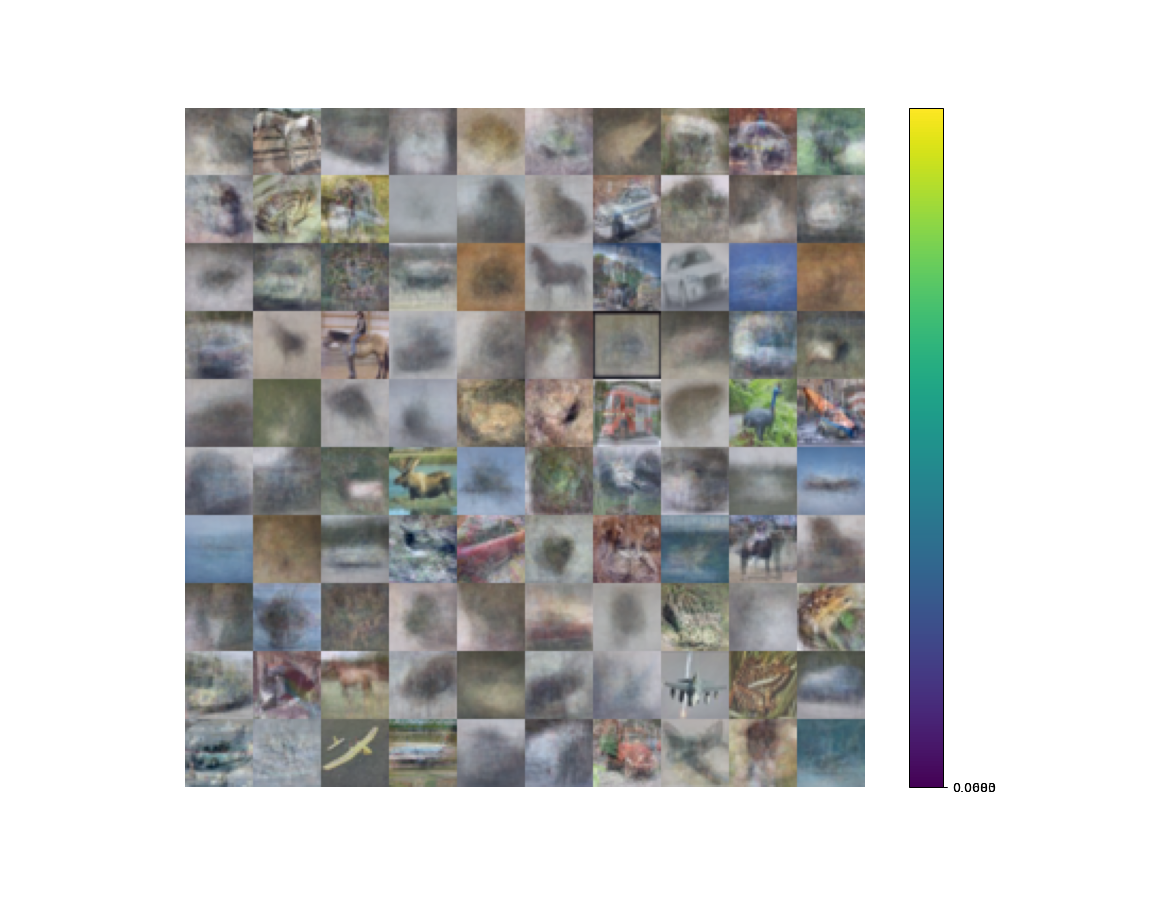

using device: cuda


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:21<00:00,  1.25it/s]

took 801.9027s to run 1000 epochs


In [72]:
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
print('using device: {}'.format(device))

start = time.time()

synapses = train_weights(x_train, N_hid, N_batch, Nep, device=device).to(device)

print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1b-2FNqVQ1fN-eixeTO9WZin9eNl2gqou/view?usp=sharing)


In [73]:
# save your own model
np.save('CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.npy'.format(N_hid, Nep, eps0, N_batch), detach(synapses))

In [111]:
# load a pre-trained model
synapses = np.load('CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.npy'.format(N_hid, Nep, eps0, N_batch), detach(synapses))

<IPython.core.display.Javascript object>


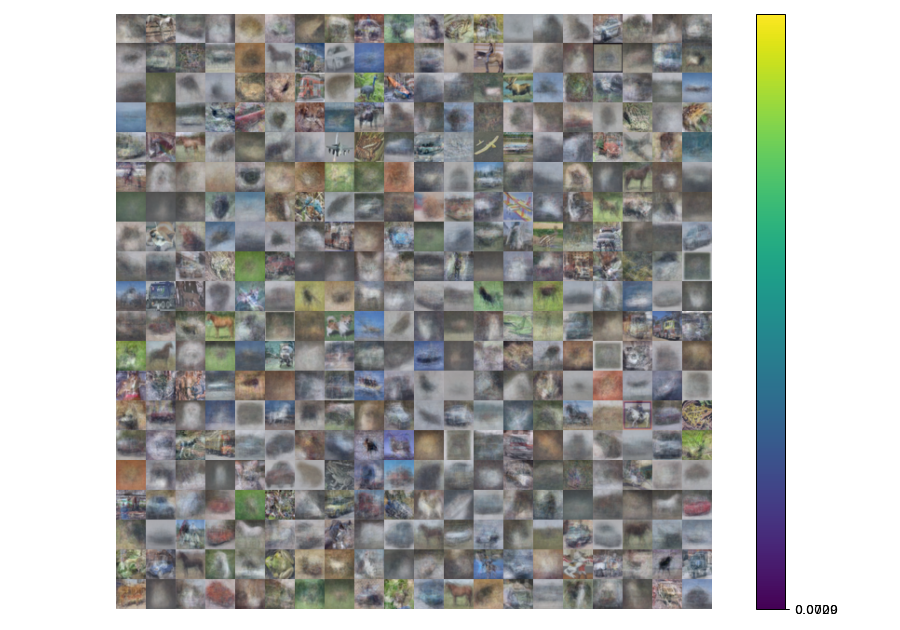

In [74]:
# %matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(detach(synapses), Kx*2, Ky*2)
plt.tight_layout()
plt.savefig('CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.pdf'.format(N_hid, Nep, eps0, N_batch))

In [75]:
def normalize(x):
    x_norm = x - np.mean(x, axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return attach(x_norm)

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [76]:
# Center and normalize input data to unit vectors  
synapses = attach(synapses)
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_test, training=False)

n=4.5
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n
x_hid_test = (x_hid_test * (x_hid_test>0)) ** n


could not move data to cuda


In [77]:
# convert everything to numpy tensors
x_hid_train = detach(x_hid_train)
x_hid_val = detach(x_hid_val)
x_hid_test = detach(x_hid_test)

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with `softmax activation`
- Loss function is the `categorical cross-entropy`
- Optimizer is `Adam` with initial learning rate of 0.1 which decays exponentially every `20` epochs with a decay rate of `0.5`
- Batch size is `10` and number of epochs is `500`

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [82]:
bio_model = keras.Sequential([
    tf.keras.layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.BatchNormalization(),
    layers.Activation('softmax')
])

print(bio_model.summary())

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=4e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

bio_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_test, y_test), batch_size=100, epochs=Nep//2, verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                20010     
_________________________________________________________________
batch_normalization_8 (Batch (None, 10)                40        
_________________________________________________________________
activation_10 (Activation)   (None, 10)                0         
Total params: 20,050
Trainable params: 20,030
Non-trainable params: 20
_________________________________________________________________
None
Train on 45000 samples, validate on 10000 samples
Epoch 1/500
45000/45000 [==============================] - 1s 18us/sample - loss: 1.9453 - accuracy: 0.3072 - val_loss: 1.8524 - val_accuracy: 0.3632
Epoch 2/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.6899 - accuracy: 0.4087 - val_loss: 1.6488 - val_accuracy: 0.4125
Epoch 3/500
45000/45000 

45000/45000 [==============================] - 0s 9us/sample - loss: 1.3232 - accuracy: 0.5303 - val_loss: 1.4895 - val_accuracy: 0.4905
Epoch 51/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.3180 - accuracy: 0.5336 - val_loss: 1.5250 - val_accuracy: 0.4647
Epoch 52/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.3143 - accuracy: 0.5323 - val_loss: 1.5330 - val_accuracy: 0.4706
Epoch 53/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.3174 - accuracy: 0.5330 - val_loss: 1.5165 - val_accuracy: 0.4850
Epoch 54/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.3140 - accuracy: 0.5301 - val_loss: 1.5037 - val_accuracy: 0.4908
Epoch 55/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.3153 - accuracy: 0.5325 - val_loss: 1.4933 - val_accuracy: 0.4907
Epoch 56/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.3176 - accuracy: 0.5299 - v

45000/45000 [==============================] - 0s 9us/sample - loss: 1.2617 - accuracy: 0.5512 - val_loss: 1.5094 - val_accuracy: 0.4800
Epoch 105/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2645 - accuracy: 0.5498 - val_loss: 1.5106 - val_accuracy: 0.4869
Epoch 106/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.2626 - accuracy: 0.5497 - val_loss: 1.5174 - val_accuracy: 0.4877
Epoch 107/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2606 - accuracy: 0.5496 - val_loss: 1.4950 - val_accuracy: 0.4919
Epoch 108/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2622 - accuracy: 0.5484 - val_loss: 1.5182 - val_accuracy: 0.4827
Epoch 109/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2622 - accuracy: 0.5497 - val_loss: 1.5255 - val_accuracy: 0.4740
Epoch 110/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2592 - accuracy: 0.552

45000/45000 [==============================] - 0s 9us/sample - loss: 1.2342 - accuracy: 0.5586 - val_loss: 1.4979 - val_accuracy: 0.4868
Epoch 159/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2361 - accuracy: 0.5588 - val_loss: 1.5114 - val_accuracy: 0.4863
Epoch 160/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2339 - accuracy: 0.5594 - val_loss: 1.5004 - val_accuracy: 0.4923
Epoch 161/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2354 - accuracy: 0.5584 - val_loss: 1.4970 - val_accuracy: 0.4939
Epoch 162/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.2349 - accuracy: 0.5604 - val_loss: 1.5206 - val_accuracy: 0.4803
Epoch 163/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.2366 - accuracy: 0.5581 - val_loss: 1.5008 - val_accuracy: 0.4862
Epoch 164/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.2340 - accuracy: 0.5

45000/45000 [==============================] - 0s 9us/sample - loss: 1.2195 - accuracy: 0.5619 - val_loss: 1.5029 - val_accuracy: 0.4879
Epoch 213/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2146 - accuracy: 0.5663 - val_loss: 1.5069 - val_accuracy: 0.4897
Epoch 214/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2174 - accuracy: 0.5665 - val_loss: 1.5037 - val_accuracy: 0.4884
Epoch 215/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2185 - accuracy: 0.5632 - val_loss: 1.5009 - val_accuracy: 0.4889
Epoch 216/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2157 - accuracy: 0.5654 - val_loss: 1.5043 - val_accuracy: 0.4842
Epoch 217/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2162 - accuracy: 0.5636 - val_loss: 1.4998 - val_accuracy: 0.4882
Epoch 218/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2165 - accuracy: 0.5653

45000/45000 [==============================] - 0s 9us/sample - loss: 1.2014 - accuracy: 0.5718 - val_loss: 1.5040 - val_accuracy: 0.4945
Epoch 267/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.2010 - accuracy: 0.5732 - val_loss: 1.4944 - val_accuracy: 0.4955
Epoch 268/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1955 - accuracy: 0.5722 - val_loss: 1.4950 - val_accuracy: 0.4971
Epoch 269/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1970 - accuracy: 0.5722 - val_loss: 1.4955 - val_accuracy: 0.4956
Epoch 270/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1966 - accuracy: 0.5762 - val_loss: 1.4975 - val_accuracy: 0.4908
Epoch 271/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1966 - accuracy: 0.5741 - val_loss: 1.4990 - val_accuracy: 0.4917
Epoch 272/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1967 - accuracy: 0.5729

45000/45000 [==============================] - 1s 12us/sample - loss: 1.1916 - accuracy: 0.5753 - val_loss: 1.4978 - val_accuracy: 0.4945
Epoch 321/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.1879 - accuracy: 0.5773 - val_loss: 1.4963 - val_accuracy: 0.4965
Epoch 322/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1875 - accuracy: 0.5754 - val_loss: 1.5071 - val_accuracy: 0.4929
Epoch 323/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1923 - accuracy: 0.5741 - val_loss: 1.4935 - val_accuracy: 0.4985
Epoch 324/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1889 - accuracy: 0.5757 - val_loss: 1.4965 - val_accuracy: 0.4954
Epoch 325/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1885 - accuracy: 0.5760 - val_loss: 1.4977 - val_accuracy: 0.4946
Epoch 326/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1891 - accuracy: 0.57

45000/45000 [==============================] - 0s 10us/sample - loss: 1.1855 - accuracy: 0.5764 - val_loss: 1.4965 - val_accuracy: 0.4973
Epoch 375/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1865 - accuracy: 0.5763 - val_loss: 1.5005 - val_accuracy: 0.4960
Epoch 376/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.1834 - accuracy: 0.5794 - val_loss: 1.4997 - val_accuracy: 0.4939
Epoch 377/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1845 - accuracy: 0.5770 - val_loss: 1.4957 - val_accuracy: 0.4975
Epoch 378/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1867 - accuracy: 0.5779 - val_loss: 1.4959 - val_accuracy: 0.4969
Epoch 379/500
45000/45000 [==============================] - 0s 10us/sample - loss: 1.1849 - accuracy: 0.5778 - val_loss: 1.4998 - val_accuracy: 0.4919
Epoch 380/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1842 - accuracy: 0.5

45000/45000 [==============================] - 0s 9us/sample - loss: 1.1818 - accuracy: 0.5804 - val_loss: 1.5011 - val_accuracy: 0.4946
Epoch 429/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1818 - accuracy: 0.5778 - val_loss: 1.4979 - val_accuracy: 0.4949
Epoch 430/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1803 - accuracy: 0.5781 - val_loss: 1.4983 - val_accuracy: 0.4951
Epoch 431/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1821 - accuracy: 0.5790 - val_loss: 1.4954 - val_accuracy: 0.4984
Epoch 432/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1821 - accuracy: 0.5780 - val_loss: 1.4998 - val_accuracy: 0.4937
Epoch 433/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1794 - accuracy: 0.5798 - val_loss: 1.4990 - val_accuracy: 0.4954
Epoch 434/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1783 - accuracy: 0.5802

45000/45000 [==============================] - 0s 9us/sample - loss: 1.1791 - accuracy: 0.5806 - val_loss: 1.4959 - val_accuracy: 0.4978
Epoch 483/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1816 - accuracy: 0.5769 - val_loss: 1.4977 - val_accuracy: 0.4933
Epoch 484/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1806 - accuracy: 0.5802 - val_loss: 1.5001 - val_accuracy: 0.4985
Epoch 485/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1782 - accuracy: 0.5780 - val_loss: 1.4980 - val_accuracy: 0.4950
Epoch 486/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1802 - accuracy: 0.5804 - val_loss: 1.4976 - val_accuracy: 0.4965
Epoch 487/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1791 - accuracy: 0.5800 - val_loss: 1.4969 - val_accuracy: 0.4950
Epoch 488/500
45000/45000 [==============================] - 0s 9us/sample - loss: 1.1788 - accuracy: 0.5801

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [85]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation="softmax")
])

bp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1000, epochs=20, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 4s 86us/sample - loss: 1.9522 - accuracy: 0.3881 - val_loss: 2.2065 - val_accuracy: 0.1564
Epoch 2/20
45000/45000 [==============================] - 4s 79us/sample - loss: 1.3917 - accuracy: 0.5149 - val_loss: 2.1922 - val_accuracy: 0.1610
Epoch 3/20
45000/45000 [==============================] - 3s 77us/sample - loss: 1.2498 - accuracy: 0.5691 - val_loss: 2.1618 - val_accuracy: 0.1920
Epoch 4/20
45000/45000 [==============================] - 3s 76us/sample - loss: 1.1402 - accuracy: 0.6076 - val_loss: 2.1059 - val_accuracy: 0.2372
Epoch 5/20
45000/45000 [==============================] - 4s 81us/sample - loss: 1.0491 - accuracy: 0.6418 - val_loss: 2.0433 - val_accuracy: 0.2764
Epoch 6/20
45000/45000 [==============================] - 4s 79us/sample - loss: 0.9567 - accuracy: 0.6768 - val_loss: 1.9486 - val_accuracy: 0.3280
Epoch 7/20
45000/45000 [==============================] -

## Plot losses and accuracies

<IPython.core.display.Javascript object>


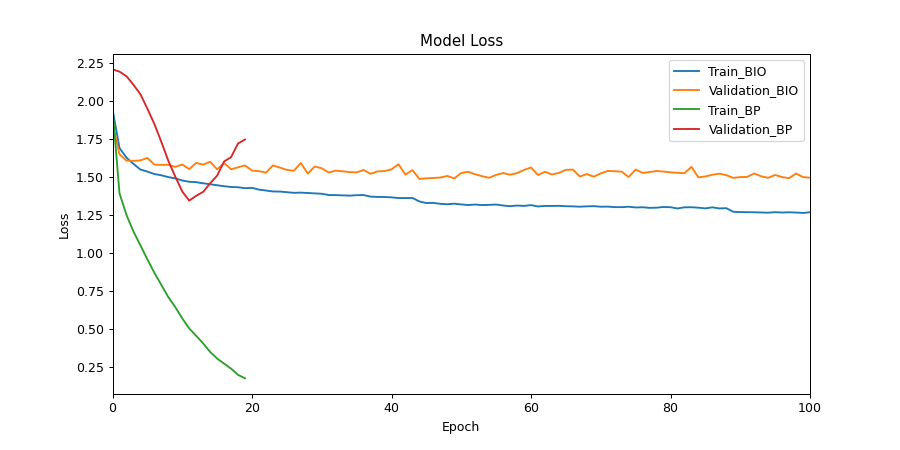

<IPython.core.display.Javascript object>


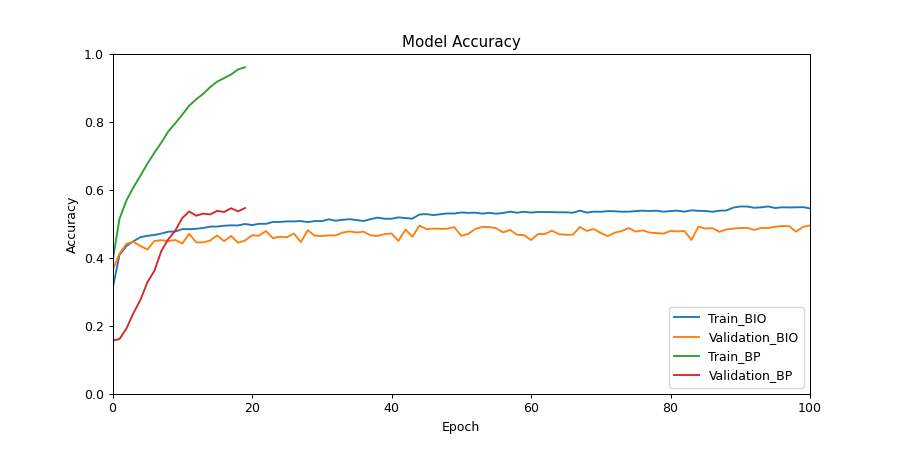

In [101]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['accuracy'])
plt.plot(bio_history['val_accuracy'])

plt.plot(bp_history['accuracy'])
plt.plot(bp_history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

In [102]:
print('BIO best validation accuracy:', max(bio_history['val_accuracy']))
print('BP best validation accuracy:', max(bp_history['val_accuracy']))

BIO best validation accuracy: 0.4997
BP best validation accuracy: 0.5466


## Plot weights of the BP model

<IPython.core.display.Javascript object>


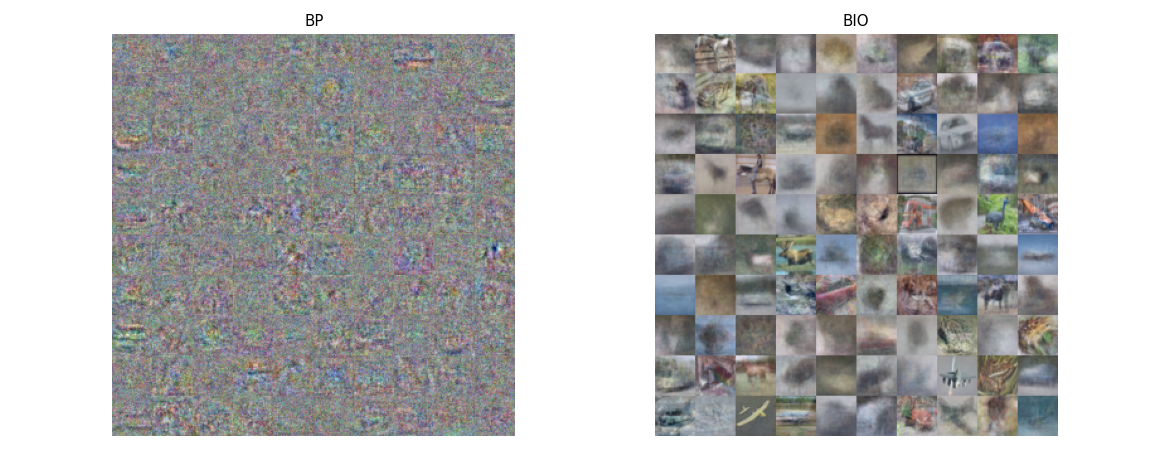

In [103]:
# %matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(detach(synapses), Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A linear model with the same architecture
If a linear model with one hidden layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [100]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.Dense(N_hid),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(detach(x_train0), y_train, validation_data=(detach(x_val0), y_val), batch_size=1000, epochs=10, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 4s 87us/sample - loss: 11.9458 - accuracy: 0.2173 - val_loss: 2.3283 - val_accuracy: 0.2842
Epoch 2/10
45000/45000 [==============================] - 4s 81us/sample - loss: 1.8850 - accuracy: 0.3352 - val_loss: 1.8397 - val_accuracy: 0.3696
Epoch 3/10
45000/45000 [==============================] - 4s 84us/sample - loss: 1.8022 - accuracy: 0.3692 - val_loss: 1.8054 - val_accuracy: 0.3692
Epoch 4/10
45000/45000 [==============================] - 4s 81us/sample - loss: 1.7815 - accuracy: 0.3760 - val_loss: 1.7721 - val_accuracy: 0.3734
Epoch 5/10
45000/45000 [==============================] - 4s 80us/sample - loss: 1.7676 - accuracy: 0.3832 - val_loss: 1.7636 - val_accuracy: 0.3848
Epoch 6/10
45000/45000 [==============================] - 4s 85us/sample - loss: 1.7514 - accuracy: 0.3923 - val_loss: 1.7475 - val_accuracy: 0.3846
Epoch 7/10
45000/45000 [==============================] 

In [105]:
print("Final Training Accuracy:", control_logs.history['accuracy'][-1])
print("Final Validation Accuracy:", control_logs.history['val_accuracy'][-1])

Final Training Accuracy: 0.41222224
Final Validation Accuracy: 0.3956
